# Fashion-MNIST 'FP16'
### Goal 
##### 1) keras classification model on MNIST Fashion Dataset 
##### 3) Otimizing the pb graph of the model using tensorrt 
##### 4) Checking the performance difference b/w tensorflow and tensorrt while doing inferencing



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Fashion MNIST Dataset Loaded

In [2]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


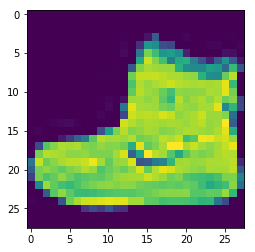

In [3]:
# Show one of the images from the training dataset
plt.imshow(x_train[0])

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# MODEL
A keras model using conv2d layer is built

In [5]:
model = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1),name='first')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax',name='last'))
# Take a look at the model summary
model.summary()

W0716 11:44:19.213308 139817274914560 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Conv2D)               (None, 28, 28, 128)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

###### model is compiled along with Adam optimizer along with categorical_crossentropy  for loss calculation

In [6]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Dividing the train dataset into train and validation as crossentropy take binary input so all the classes are converted in binary form using to_categorical

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, y_val = train_test_split(x_train, y_train, test_size=0.1666, random_state=42)
print(X_train.shape)

print(Y_train.shape)
print(x_train.shape)
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)
y_val = to_categorical(y_val)
print(Y_train.shape)


(50004, 28, 28)
(50004,)
(60000, 28, 28)
(50004, 10)


##### Model training checking its accuracy validation data

In [8]:
X_train= X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
model.fit(X_train,
         Y_train,
         batch_size=64,
         epochs=10,
         validation_data=(X_val, y_val))


Train on 50004 samples, validate on 9996 samples
Epoch 1/10
50004/50004 [==============================] - 16s 313us/sample - loss: 0.5547 - acc: 0.7971 - val_loss: 0.3771 - val_acc: 0.8675
Epoch 2/10
50004/50004 [==============================] - 15s 306us/sample - loss: 0.3387 - acc: 0.8769 - val_loss: 0.3342 - val_acc: 0.8767
Epoch 3/10
50004/50004 [==============================] - 15s 303us/sample - loss: 0.2928 - acc: 0.8926 - val_loss: 0.2811 - val_acc: 0.8976
Epoch 4/10
50004/50004 [==============================] - 16s 311us/sample - loss: 0.2635 - acc: 0.9035 - val_loss: 0.2722 - val_acc: 0.9001
Epoch 5/10
50004/50004 [==============================] - 15s 306us/sample - loss: 0.2400 - acc: 0.9108 - val_loss: 0.2477 - val_acc: 0.9107
Epoch 6/10
50004/50004 [==============================] - 15s 306us/sample - loss: 0.2254 - acc: 0.9168 - val_loss: 0.2524 - val_acc: 0.9075
Epoch 7/10
50004/50004 [==============================] - 16s 315us/sample - loss: 0.2082 - acc: 0.9234 -

##### Evaluating accuracy on test dataset

In [9]:
y_test=to_categorical(y_test)
x_test =x_test.reshape(-1,28,28,1)
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9051


### To save trained model weights and biases h5 format file is saved in directory model

In [10]:
model.save('./model/modelLeNet5.h5')

In [11]:
tf.keras.backend.set_learning_phase(0) # Required when there is batch normalization layer in the model
from tensorflow.keras.models import load_model

In [12]:
name1 =[node.op.name for node in model.outputs]
print(model.get_layer('last').output)

Tensor("last/Softmax:0", shape=(?, 10), dtype=float32)


In [13]:
import os
os.getcwd()

'/workspace/gauravtrt/Fashion16'

### As keras use tensorflow in backend so by using backed.get_seesion we create meta file data file checkpoint and index using h5

In [14]:
MODEL_PATH = "/workspace/gauravtrt/Fashion16"
model = load_model('/workspace/gauravtrt/Fashion16/model/modelLeNet5.h5')

# save the model to tensorflow
saver=tf.train.Saver()
sess =tf.keras.backend.get_session()
save_path=saver.save(sess,MODEL_PATH+'/Project_data')
print("keras model sucessfully converted to tf"+MODEL_PATH)

W0716 11:46:56.080512 139817274914560 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 11:46:56.082267 139817274914560 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


keras model sucessfully converted to tf/workspace/gauravtrt/Fashion16


### Now using meta and data file pb frozen graph file is created by freezing all variables to constant 

In [36]:
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile
os.getcwd()

tf.enable_resource_variables()
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
    saver = tf.train.import_meta_graph("/workspace/gauravtrt/Fashion16/Project_data.meta")
    saver.restore(sess, "/workspace/gauravtrt/Fashion16/Project_data")
    your_outputs = ['last/Softmax']
    frozen_graph = tf.graph_util.convert_variables_to_constants(sess,tf.get_default_graph().as_graph_def(),
        output_node_names=your_outputs)
    with gfile.FastGFile("/workspace/gauravtrt/Fashion16/model/frozen_model.pb", 'wb') as f:
        f.write(frozen_graph.SerializeToString())
    print("Frozen model is successfully stored!")

Frozen model is successfully stored!


### Now we use 1000 as batch size and precision mode "FP16" for creating tensorrt pb graph

In [16]:
# convert (optimize) frozen model to TensorRT model
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,# frozen model
    outputs=your_outputs,
    max_batch_size=1000,# specify your max batch size
    max_workspace_size_bytes=3*(10**9),# specify the max workspace
    precision_mode="FP16") # precision, can be "FP32" (32 floating point precision) or "FP16"

#write the TensorRT model to be used later for inference
tf.enable_resource_variables()
with gfile.FastGFile("./model/TensorRT_model.pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())
print("TensorRT model is successfully stored!")

TensorRT model is successfully stored!


#### You can notice below number of nodes in tensorRT graph is much lesser then the frozen graph

In [17]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 47
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 37


In [18]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt # must import this although we will not use it explicitly
from tensorflow.python.platform import gfile
from PIL import Image
import numpy as np
import time
from matplotlib import pyplot as plt
import warnings
input_img=x_test
print(input_img.shape)

(10000, 28, 28, 1)


In [19]:
# function to read a ".pb" model 
# (can be used to read frozen model or TensorRT model)
def read_pb_graph(model):
  with gfile.FastGFile(model,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
  return graph_def

### Checking the inference time using tensorRT pb file 

In [26]:
# variable
TENSORRT_MODEL_PATH = './model/TensorRT_model.pb'

graph = tf.Graph()
# warnings.filterwarnings("ignore")
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
        # read TensorRT model
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input = sess.graph.get_tensor_by_name('first_input:0')
        output = sess.graph.get_tensor_by_name('last/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 1
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
            
        avg_time_tensorRT = total_time / n_time_inference
        print("average inference time: ", avg_time_tensorRT)

needed time in inference-0:  0.87589430809021
average inference time:  0.87589430809021


##### Inference time for tensorRt model is 0.87589430809021 sec

#### Checking the inference time using tensorflow frozen model pb file

In [30]:
FROZEN_MODEL_PATH = './model/frozen_model.pb'

graph = tf.Graph()
# warnings.filterwarnings("ignore")
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(frozen_graph, name='')
        input = sess.graph.get_tensor_by_name('first_input:0')
        output = sess.graph.get_tensor_by_name('last/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 1
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ",delta_time) 
            #print(delta_time)
        avg_time_original_model = total_time / n_time_inference
        print("average inference time: ", avg_time_original_model)
        print("TensorRT improvement compared to the original model:", avg_time_original_model/avg_time_tensorRT)

needed time in inference-0:  0.9845216274261475
average inference time:  0.9845216274261475
TensorRT improvement compared to the original model: 1.1240187524140752


#### You can see from the above model that tensorRt inference time is 12% faster here on such a small model 

## Batch size 1 and "FP16" as precision Mode

In [37]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,# frozen model
    outputs=your_outputs,
    max_batch_size=1,# specify your max batch size
    max_workspace_size_bytes=3*(10**9),# specify the max workspace
    precision_mode="FP16") # precision, can be "FP32" (32 floating point precision) or "FP16"

#write the TensorRT model to be used later for inference
tf.enable_resource_variables()
with gfile.FastGFile("./model/TensorRT_model.pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())
print("TensorRT model is successfully stored!")

TensorRT model is successfully stored!


In [38]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 47
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 37


In [43]:
# variable
TENSORRT_MODEL_PATH = './model/TensorRT_model.pb'

graph = tf.Graph()
# warnings.filterwarnings("ignore")
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
        # read TensorRT model
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input = sess.graph.get_tensor_by_name('first_input:0')
        output = sess.graph.get_tensor_by_name('last/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 1
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ", delta_time)
            
        avg_time_tensorRT = total_time / n_time_inference
        print("average inference time: ", avg_time_tensorRT)

needed time in inference-0:  0.888181209564209
average inference time:  0.888181209564209


In [57]:
FROZEN_MODEL_PATH = './model/frozen_model.pb'

graph = tf.Graph()
# warnings.filterwarnings("ignore")
with graph.as_default():
    with tf.Session() as sess:
        # read TensorRT model
        frozen_graph = read_pb_graph(FROZEN_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(frozen_graph, name='')
        input = sess.graph.get_tensor_by_name('first_input:0')
        output = sess.graph.get_tensor_by_name('last/Softmax:0')

        # in this case, it demonstrates to perform inference for 50 times
        total_time = 0; n_time_inference = 1
        out_pred = sess.run(output, feed_dict={input: input_img})
        for i in range(n_time_inference):
            t1 = time.time()
            out_pred = sess.run(output, feed_dict={input: input_img})
            t2 = time.time()
            delta_time = t2 - t1
            total_time += delta_time
            print("needed time in inference-" + str(i) + ": ",delta_time) 
            #print(delta_time)
        avg_time_original_model = total_time / n_time_inference
        print("average inference time: ", avg_time_original_model)
        print("TensorRT improvement compared to the original model:", avg_time_original_model/avg_time_tensorRT)

needed time in inference-0:  0.9398398399353027
average inference time:  0.9398398399353027
TensorRT improvement compared to the original model: 1.0581622644284947


### Using reduced batch size we are able to get 5% faster inference using tensorRt then tensorflow